In [29]:
import numpy as np
import pandas as pd
import spacy
import en_core_web_sm
from spacy.tokenizer import Tokenizer
import timeit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import seaborn as sns


import re
import random
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib
from scipy import sparse
from math import sqrt


In [3]:
# loading articles
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv("NEWS.csv").iloc[:,:-1]
df = df[:100]                               # to limit the size of the corpus
art = df['Summary']
art.head()

0    Padlocks^ shackles and chains are used to cove...
1    Kyrgyzstan is a close ally of Russia and has l...
2    The talks follow recent tensions between China...
3    China^ which claims democratic Taiwan as its o...
4    The fighting erupted September 27 and has kill...
Name: Summary, dtype: object

In [4]:
df.head()

,Id,Title,Summary,Date,Link
0,1,Locks^ chains: Coronavirus puts Indonesia's me...,Padlocks^ shackles and chains are used to cove...,07 Oct 2020,https://www.indiatoday.in/world/asia/071020/lo...
1,2,Opposition in Kyrgyzstan claim power after sto...,Kyrgyzstan is a close ally of Russia and has l...,06 Oct 2020,https://www.indiatoday.in/world/asia/061020/op...
2,3,India^ US^ Australia^ Japan to discuss China's...,The talks follow recent tensions between China...,06 Oct 2020,https://www.indiatoday.in/world/asia/061020/in...
3,4,Taiwan says military under pressure from China...,China^ which claims democratic Taiwan as its o...,06 Oct 2020,https://www.indiatoday.in/world/asia/061020/ta...
4,5,Armenia^ Azerbaijan clashes resume over separa...,The fighting erupted September 27 and has kill...,05 Oct 2020,https://www.indiatoday.in/world/asia/051020/ar...


<h2>1. CLEANING THE ARTICLES</h2>

In [5]:
# cleanig function

# for keeping track of process, using counter
global counter
counter = 0


def cleaning(text):
    nlp = spacy.load("en_core_web_sm")

    text_lower= text.lower()                           #convert to lower case
    num_removed = re.sub("\d+", "", text_lower)        #remove numbers
    removed_lines=re.sub('\n','',num_removed)               #remove \n
    removed_html = re.compile(r'<.*?>').sub('', removed_lines)     #remove html tags
    result=removed_html

    doc = nlp(result)
    lemmas = [t.lemma_ for t in doc if t.lemma_ not in STOP_WORDS]

    no_stop = []
    puncs = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n'"
    for lemma in lemmas:
      if lemma[-1] in puncs:
          lemma = lemma[:-1]
      if lemma not in puncs and lemma.isalpha():
          no_stop.append(lemma)

    cleaned = " ".join(no_stop)
    global counter
    if counter % 10 == 0:
        print("Article no. " + str(counter))
    counter += 1

    # print(text)
    # print(cleaned)
    return cleaned



In [6]:
# performing cleaning
cleaned_art = []
print("Cleaning articles-")
for a in art:
    try:
        cleaned_each = cleaning(a)
        cleaned_art.append(cleaned_each)
    except AttributeError:
        pass

Cleaning articles-
Article no. 0
Article no. 10
Article no. 20
Article no. 30
Article no. 40
Article no. 50
Article no. 60
Article no. 70
Article no. 80
Article no. 90


In [7]:
# For saving cleaned articles as csv dataframe

# cleaned_df = pd.DataFrame(cleaned_art, columns=['Summary'])
# cleaned_df.index += 1
# cleaned_df.index.name = 'ArticleId'
# cleaned_df.to_csv('cleaned_art.csv')

<h2>2. CREATING TFIDF DATA


In [8]:
tfidf = TfidfVectorizer(
    min_df =0.0,
    max_df = 0.95,
    max_features = 3000,
    # stop_words = nlp.Defaults.stop_words,
    # vocabulary=vocab,
    ngram_range=(1,2),
)


tfidf_data = tfidf.fit_transform(cleaned_art)   # x variable name changed to 
tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns= tfidf.get_feature_names())
tfidf_df.head()

# saving as csv
# tfidf_df.to_csv("tfidf_df.csv")


,abe,abe increasingly,abe surpass,ability,ability defend,able,able handle,abu,abu sayyaf,abuse,abuse cover,abuse power,access,access covid,accord,accord report,accuse,accuse cooperate,accuse oppose,activist,activist share,activity,activity near,adapt,adapt method,add,add grow,affair,affair foreign,affair purely,affect,affect region,ages,ages highly,ago,al,al jazeera,alarming,alarming surge,alert,...,week hometown,week race,week reach,welcome,welcome hongkonger,welcome necessary,wen,wen pledge,whitewash,whitewash brutal,widespread,widespread anger,widespread flooding,wildlife,wildlife product,win,win parliamentary,winds,winds waves,wish,wish settle,withdrawal,withdrawal bilateral,work,work passes,workers,working,working rural,world,world able,world expert,world fourth,world record,world war,year,year prosecutor,yoshihide,yoshihide suga,zero,zero local
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160645,0.0,0.0,0.197393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.252647,0.252647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2>3. Transforming data

In [9]:
# AVOIDING SCALING BECAUSE GETTING SAME STRANGE CLUSTERS

# standard scaling the data
# scaler = StandardScaler()                 
# df_scaled = scaler.fit_transform(tfidf_df)
# df_scaled.shape

(100, 1726)

In [61]:
# Dimention reduction using PCA

pca_model = PCA(n_components=0.8, svd_solver='full')
pca_data = pca_model.fit_transform(tfidf_df)
pca_df = pd.DataFrame(pca_data)
pca_df.shape

(100, 75)

In [62]:
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,-0.066149,-0.039623,0.023091,-0.076365,-0.068665,-0.046914,0.032828,-0.114714,0.224139,-0.034101,0.118117,-0.010570,-0.071993,0.111108,0.132809,-0.055627,-0.228179,-0.086679,0.094976,-0.116784,0.038640,0.025973,0.011183,0.040094,0.030646,-0.126849,-0.155066,-0.194982,-0.094811,-0.129931,0.042078,-0.129967,-0.015201,-0.063427,-0.103825,0.149937,-0.202819,-0.047122,-0.071637,0.068961,0.078282,0.117786,0.029246,-0.057968,0.079156,-0.124446,-0.115473,-0.167308,0.016865,0.124282,-0.018573,-0.118972,0.328140,0.068859,-0.085072,-0.174746,0.008459,-0.000771,0.051917,-0.150865,0.035378,0.059977,-0.158588,0.121436,-0.131036,-0.017997,0.117042,0.079399,0.025129,0.061585,0.079273,0.035313,-0.233804,0.096269,0.010428
1,0.076613,-0.047523,0.137892,-0.054426,0.042113,0.043321,-0.115096,0.181661,0.079763,0.014044,-0.145838,-0.164071,-0.041567,-0.210830,-0.137059,0.087930,-0.079237,-0.200337,-0.094360,-0.203509,-0.069980,0.018438,-0.039724,0.054650,-0.054309,-0.043302,-0.060939,0.013488,0.068349,-0.064073,0.261221,-0.031684,-0.055740,0.146637,-0.070541,-0.001839,0.120242,0.081041,-0.203614,0.109734,-0.016258,0.110798,0.101852,0.176793,-0.068375,0.085790,-0.010326,-0.041170,-0.126577,0.059516,0.112037,-0.101291,-0.031780,0.113697,0.008277,-0.009386,-0.044784,0.034487,-0.039824,0.027513,-0.165597,-0.042712,-0.100843,-0.137993,-0.127607,-0.004912,-0.058029,-0.219388,0.034581,-0.050761,0.266960,-0.098578,0.029263,-0.063486,0.053346
2,0.145647,0.038397,0.026684,-0.046994,-0.017389,-0.115466,-0.079987,-0.124627,-0.139661,0.135996,-0.148559,0.182518,-0.039953,0.029026,0.010183,0.295049,-0.187621,0.170974,0.001614,-0.002794,0.164651,-0.074479,-0.195478,0.043037,-0.068723,-0.147576,0.114985,0.036351,0.035344,0.017399,-0.033588,-0.151595,0.060113,-0.034234,-0.021924,-0.032898,0.039705,-0.057443,-0.033742,0.027191,-0.019501,-0.049847,0.042241,-0.015836,0.082235,0.014514,-0.011314,0.195792,-0.096804,0.104595,-0.050058,-0.078837,-0.130721,0.016148,0.134773,-0.175931,0.105766,-0.014481,0.118263,0.050922,0.109179,0.158879,0.007188,0.108784,-0.015468,-0.175926,-0.068840,-0.113503,-0.124758,-0.014638,-0.093410,0.018397,-0.107044,0.033680,-0.019055
3,0.369309,-0.005524,0.382951,-0.186536,0.131589,0.012787,0.343203,-0.159238,-0.076476,0.102053,-0.017283,-0.167980,0.084316,-0.086643,0.031443,-0.097697,0.055627,0.045195,-0.002722,-0.007498,0.002714,0.063588,0.044921,-0.026880,-0.039189,-0.007215,-0.015161,-0.034003,0.020651,-0.015206,-0.054169,0.004553,-0.008687,-0.104991,0.059796,0.012679,-0.031296,-0.025206,0.042685,-0.064403,-0.023889,-0.007234,-0.040303,-0.041310,0.061535,0.012937,0.014191,0.022865,0.020226,0.004370,-0.065059,0.046608,0.029939,-0.066118,-0.032863,0.033375,-0.040072,-0.038404,-0.018991,0.004548,0.048175,0.011814,0.067989,0.014141,0.041647,0.000922,0.019158,0.030825,-0.019812,0.023655,-0.053306,0.028799,-0.009709,-0.007575,0.000520
4,-0.058236,-0.043899,-0.000924,-0.047203,-0.029658,0.062425,-0.108100,-0.091476,-0.100336,0.067353,0.005228,0.017798,0.064686,0.125061,-0.102511,-0.097236,-0.081921,-0.039308,0.002808,-0.036541,-0.173696,0.052886,-0.014326,0.053574,-0.146529,0.095280,-0.020848,0.002211,0.271842,0.022515,-0.055128,-0.034342,0.084454,-0.060606,-0.050467,0.152683,-0.026591,0.077573,0.344528,-0.101999,0.144791,0.083801,-0.024338,0.502337,0.053554,-0.245354,-0.032049,0.030356,-0.125779,0.046342,-0.090958,-0.035839,-0.018650,0.000786,0.007237,0.122499,0.026835,0.095735,0.007056,-0.139199,-0.005267,0.021852,0.092307,-0.084656,-0.012770,0.067666,-0.096694,0.056153,-0.023588,-0.157157,0.080114,0.176187,-0.021948,0.039699,-0.103986


<h2> 4. Clustering

Text(0.5, 1.0, 'Elbow curve')

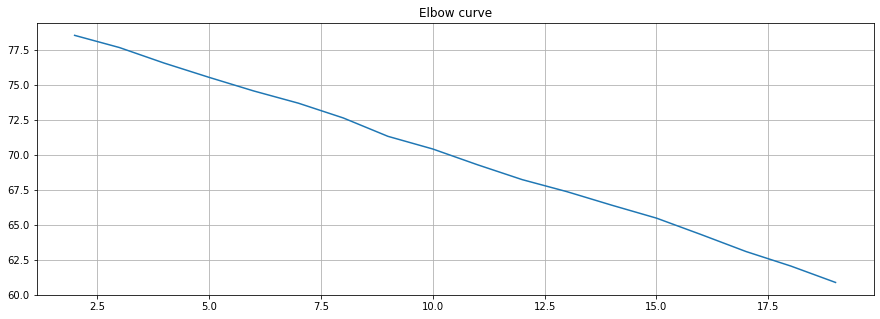

In [79]:
# Choosing K through ELBOW METHOD

distorsions = []
for k in range(2, int(sqrt(pca_df.shape[0]))*2):
    km = KMeans(n_clusters=k, max_iter = 100, verbose = 0,n_init = 1, random_state=11)
    km.fit(pca_df)
    distorsions.append(km.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, int(sqrt(pca_df.shape[0]))*2), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [64]:
# getting silhouette scores

def get_k_by_sil(start, stop, sample_size, df):
  k_number = 0
  sil_scoore = -99999
  for i in range(start, stop):
      km = KMeans(n_clusters=i, max_iter = 100, n_init = 5, random_state=11)

      clusters = km.fit(df)

      current_score = metrics.silhouette_score(df, km.labels_)
      if  current_score > sil_scoore:
          sil_scoore = current_score
          k_number = i
          # print(i)
      
      # print(str(i)+" "+str(metrics.silhouette_score(df, km.labels_, sample_size=100)))

  return k_number
  # print(k_number)

In [65]:
k = get_k_by_sil(2, int(sqrt(pca_df.shape[0]))*2, pca_df.shape[0], pca_df)
k

19

In [76]:
km = KMeans(n_clusters=k, max_iter = 100, verbose = 0, n_init = 5, random_state=11).fit(pca_df)

In [77]:
kmeans_df = pd.DataFrame()
kmeans_df['cluster'] = km.labels_
kmeans_df['stemmed'] = df['Summary']

In [78]:
kmeans_df['cluster'].value_counts()

16    14
3     11
11    10
2      8
12     7
7      7
10     6
17     6
4      6
14     5
6      5
9      3
15     3
1      3
8      2
18     1
5      1
13     1
0      1
Name: cluster, dtype: int64

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18')]

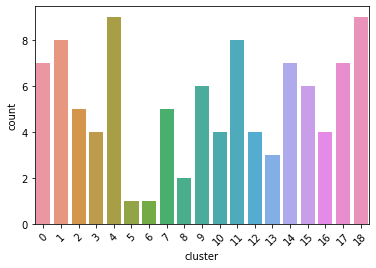

In [75]:
ax = sns.countplot(x= 'cluster', data=kmeans_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)